In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [4]:
import numpy as np
from tqdm import tqdm
from pathlib import Path
import openslide
import pandas as pd

In [5]:
from fastai.callbacks.csv_logger import CSVLogger

In [6]:
from object_detection_fastai.helper.object_detection_helper import *
from object_detection_fastai.helper.wsi_loader import *
from object_detection_fastai.loss.RetinaNetFocalLoss import RetinaNetFocalLoss
from object_detection_fastai.models.RetinaNet import RetinaNet
from object_detection_fastai.callbacks.callbacks import BBLossMetrics, BBMetrics, PascalVOCMetric, PascalVOCMetricByDistance

In [7]:
slides_train = list(set(['BAL Promyk Spray 4.svs',
                         'BAL AIA Blickfang Luft.svs']))

slides_val = list(set(['BAL 1 Spray 2.svs', 
                         'BAL Booker Spray 3.svs',
                         'BAL Bubi Spray 1.svs', 
                         'BAL cent blue Luft 2.svs']))

labels = ['Schrott']

In [8]:
experiment_name = "Asthma-L0"

In [9]:
annotations_path = Path("../Statistics/Asthma_Annotations.pkl")
annotations = pd.read_pickle(annotations_path)

annotations = annotations[annotations["class"].isin(labels)]
annotations_train = annotations[annotations["image_name"].isin(slides_train)]
annotations_val = annotations[annotations["image_name"].isin(slides_val)]
annotations_train.head()

,id,image_id,image_name,image_set,class,vector,unique_identifier,user_id,deleted,last_editor
21105,140917,226,BAL Promyk Spray 4.svs,14,Makrophagen,"{'x1': 14371, 'x2': 14435, 'y1': 14738, 'y2': ...",2c2f610e-f4f7-4e05-8236-ffa28418550d,10,False,None
21106,140918,226,BAL Promyk Spray 4.svs,14,Makrophagen,"{'x1': 14066, 'x2': 14152, 'y1': 14692, 'y2': ...",bcf159fc-2a41-4a69-a4cd-9b48da8fc663,10,False,None
21107,140919,226,BAL Promyk Spray 4.svs,14,Makrophagen,"{'x1': 14377, 'x2': 14451, 'y1': 14646, 'y2': ...",f5e247d5-9c38-4e22-9329-56805024cf83,10,False,None
21108,140920,226,BAL Promyk Spray 4.svs,14,Makrophagen,"{'x1': 14304, 'x2': 14384, 'y1': 14600, 'y2': ...",f68910d0-eb8f-4715-ad8d-accd060efff1,10,False,None
21109,140921,226,BAL Promyk Spray 4.svs,14,Makrophagen,"{'x1': 14318, 'x2': 14402, 'y1': 14544, 'y2': ...",013f3fc1-b603-41ce-8357-e446db2c9a14,10,False,None


In [11]:
slides_path = Path("../Slides")
files = {slide.name: slide for slide in slides_path.rglob("*.svs") if slide.name in slides_train + slides_val}
files

{'BAL 1 Spray 2.svs': WindowsPath('../Slides/BAL 1 Spray 2.svs'),
 'BAL AIA Blickfang Luft.svs': WindowsPath('../Slides/BAL AIA Blickfang Luft.svs'),
 'BAL Booker Spray 3.svs': WindowsPath('../Slides/BAL Booker Spray 3.svs'),
 'BAL Bubi Spray 1.svs': WindowsPath('../Slides/BAL Bubi Spray 1.svs'),
 'BAL cent blue Luft 2.svs': WindowsPath('../Slides/BAL cent blue Luft 2.svs'),
 'BAL Promyk Spray 4.svs': WindowsPath('../Slides/BAL Promyk Spray 4.svs')}

In [12]:
size = 1024 
level = 0
bs = 16
train_images = 500
val_images = 500

In [13]:
train_files = []
val_files = []

In [14]:
for image_name in annotations_train["image_name"].unique():
    
    annotations = annotations_train[annotations_train["image_name"] == image_name]
    annotations = annotations[annotations["deleted"] == False]
    
    slide_path = files[image_name]
    labels =  list(annotations["class"])
    bboxes = [[vector["x1"], vector["y1"], vector["x2"], vector["y2"]] for vector in annotations["vector"]]
    
    for label in labels:
        if label not in set(labels):
            bboxes.append([0,0,0,0])
            labels.append(label)

    train_files.append(SlideContainer(slide_path, y=[bboxes, labels],  level=level, width=size, height=size))
    
for image_name in annotations_val["image_name"].unique():
    
    annotations = annotations_val[annotations_val["image_name"] == image_name]
    annotations = annotations[annotations["deleted"] == False]
    
    slide_path = files[image_name]
    labels =  list(annotations["class"])
    bboxes = [[vector["x1"], vector["y1"], vector["x2"], vector["y2"]] for vector in annotations["vector"]]
    
    for label in labels:
        if label not in set(labels):
            bboxes.append([0,0,0,0])
            labels.append(label)

    val_files.append(SlideContainer(slide_path, y=[bboxes, labels],  level=level, width=size, height=size))

train_files = list(np.random.choice(train_files, train_images))
valid_files = list(np.random.choice(val_files, val_images))

In [15]:
tfms = get_transforms(do_flip=True,
                      flip_vert=True,
                      #max_rotate=90,
                      #max_lighting=0.0,
                      #max_zoom=1.,
                      #max_warp=0.0,
                      #p_affine=0.5,
                      #p_lighting=0.0,
                      #xtra_tfms=xtra_tfms,
                     )

In [16]:
def get_y_func(x):
    return x.y

In [17]:
train =  ObjectItemListSlide(train_files, path=slides_path)
valid = ObjectItemListSlide(valid_files, path=slides_path)
item_list = ItemLists(slides_path, train, valid)
lls = item_list.label_from_func(get_y_func, label_cls=SlideObjectCategoryList) #
lls = lls.transform(tfms, tfm_y=True, size=size)
data = lls.databunch(bs=bs, collate_fn=bb_pad_collate, num_workers=0).normalize()

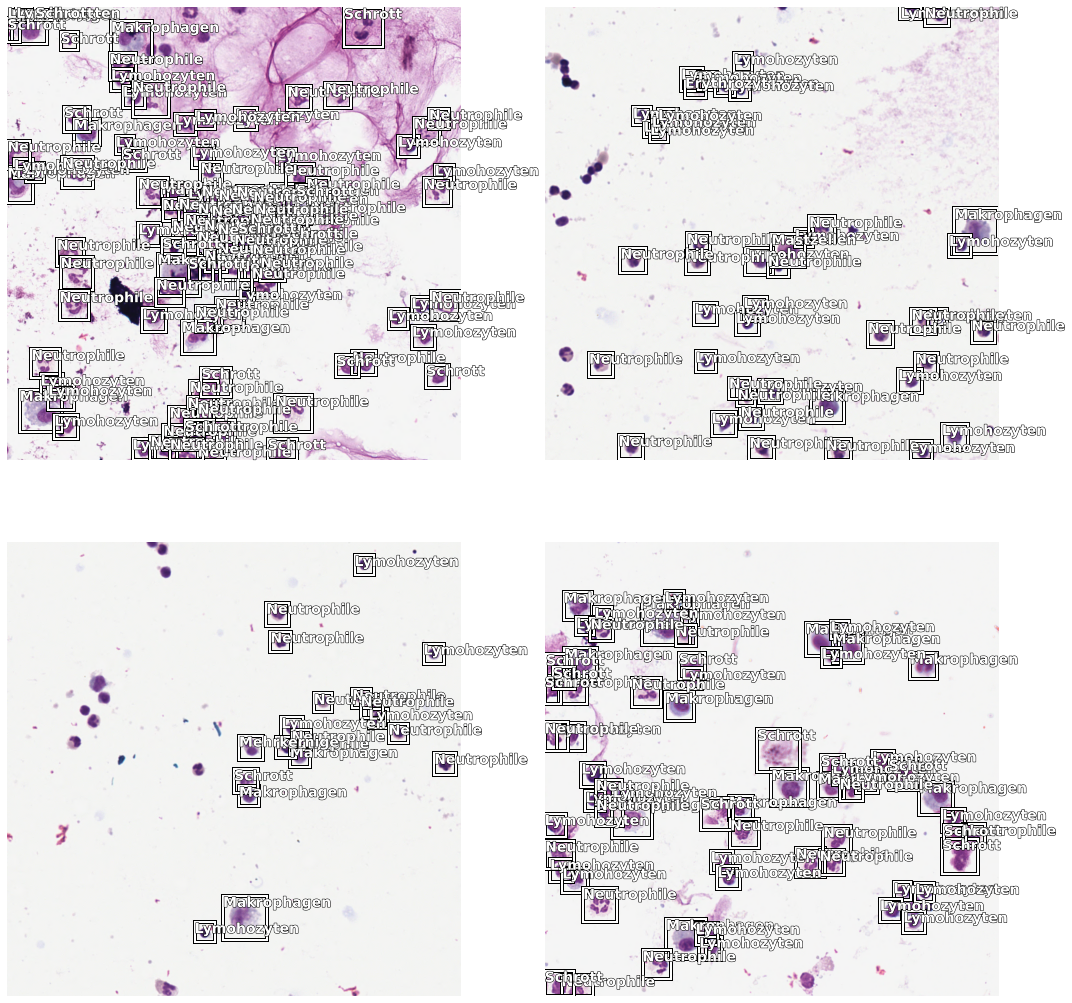

In [23]:
data.show_batch(rows=2, ds_type=DatasetType.Valid, figsize=(15,15))